Spooky intel patch

In [1]:
!zip project.zip /notebooks/3ML3 Project/*

	zip warning: name not matched: /notebooks/3ML3
	zip warning: name not matched: Project/*

zip error: Nothing to do! (project.zip)


In [1]:
%pip install scikit-learn-intelex
from sklearnex import patch_sklearn 

patch_sklearn()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 24.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 19.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 98.9 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import re
import string
import spacy
from tqdm.auto import tqdm
import time
import numpy as np
import seaborn as sns
#from nltk.probability import FreqDist
import time


#from yellowbrick.text import FreqDistVisualizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
#import matplotlib.font_manager
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt

Loading the Info

In [2]:
data = pd.read_csv("/notebooks/3ML3 Project/GPT-wiki-intro.csv")


Testing the data for nulls, duplicates

In [4]:
data.info()

print("\n")
print(data.isnull().sum())

print("\n")
print(data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     150000 non-null  int64 
 1   url                    150000 non-null  object
 2   title                  150000 non-null  object
 3   wiki_intro             150000 non-null  object
 4   generated_intro        150000 non-null  object
 5   title_len              150000 non-null  int64 
 6   wiki_intro_len         150000 non-null  int64 
 7   generated_intro_len    150000 non-null  int64 
 8   prompt                 150000 non-null  object
 9   generated_text         150000 non-null  object
 10  prompt_tokens          150000 non-null  int64 
 11  generated_text_tokens  150000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 13.7+ MB


id                       0
url                      0
title                    0
wiki_intro               0


Taking in data, encoding labels

In [5]:
final_table_columns = ['wiki_intro', 'generated_intro', 'wiki_intro_len', 'generated_intro_len']
new_df = data.drop(columns=[col for col in data if col not in final_table_columns])
new_df.head()

wiki_intro  \
0  Sexhow railway station was a railway station b...   
1  In Finnish folklore, all places and things, an...   
2  In mathematics, specifically differential calc...   
3  is a Japanese shōjo manga series written and i...   
4  Robert Milner "Rob" Bradley, Jr. (born August ...   

                                     generated_intro  wiki_intro_len  \
0  Sexhow railway station was a railway station l...             174   
1  In Finnish folklore, all places and things, an...             187   
2  In mathematics, specifically differential calc...             170   
3  is a Japanese shōjo manga series written and i...             335   
4  Robert Milner "Rob" Bradley, Jr. (born August ...             170   

   generated_intro_len  
0                   78  
1                   80  
2                   59  
3                  121  
4                  136

In [6]:
h_df = new_df[['wiki_intro', 'wiki_intro_len']]
g_df = new_df[['generated_intro', 'generated_intro_len']]

h_df = h_df.rename({'wiki_intro':'text', 'wiki_intro_len':'length'}, axis='columns')
g_df = g_df.rename({'generated_intro':'text', 'generated_intro_len':'length'}, axis='columns')

h_df['is_generated'] = 0
g_df['is_generated'] = 1
wiki = pd.concat([h_df, g_df], ignore_index=True)

Data Processing

In [16]:
# Stopwords

# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)



#time

tqdm.pandas(desc="Pre-Processing Data")

wiki['text'] = wiki['text'].progress_apply(preprocess_text)



Pre-Processing Data:   0%|          | 0/300000 [00:00<?, ?it/s]

Importing already preprocessed data

In [3]:
wiki = pd.read_csv("/notebooks/3ML3 Project/wiki_lemma.csv")

In [4]:
wiki

text  length  \
0       sexhow railway station railway station build s...     174   
1       finnish folklore , place thing , human being ,...     187   
2       mathematic , specifically differential calculu...     170   
3       japanese shōjo manga series write illustrate r...     335   
4       robert milner " rob " bradley , jr. ( bear aug...     170   
...                                                   ...     ...   
299995  randy borum professor coordinator master fine ...      71   
299996  sa'och ( , , " sauch " ) endanger , nuclear - ...     134   
299997  philip c. hanawalt ( bear 1931 ) american grap...     191   
299998  vossius gymnasium public gymnasium town vossiu...     108   
299999  simone stratigo ( , symeon filippos stratigos ...     132   

        is_generated  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
299995             1  
299996             1  
299997             1  
299998             1  
299999             1  

[300000 rows x 3 columns]

## Text Visualization and Exploratory Data Analysis

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

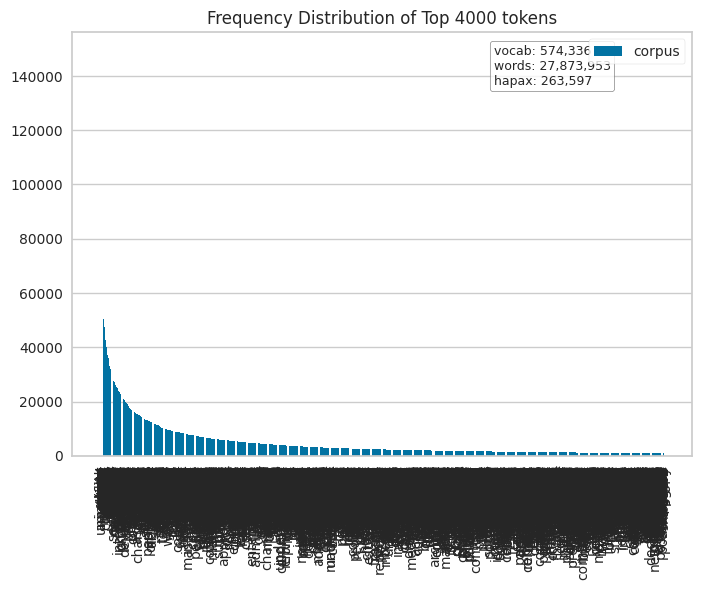

<AxesSubplot: title={'center': 'Frequency Distribution of Top 4000 tokens'}>

In [8]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(wiki["text"])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v', n=4000)
visualizer.fit(docs)
visualizer.show()

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found

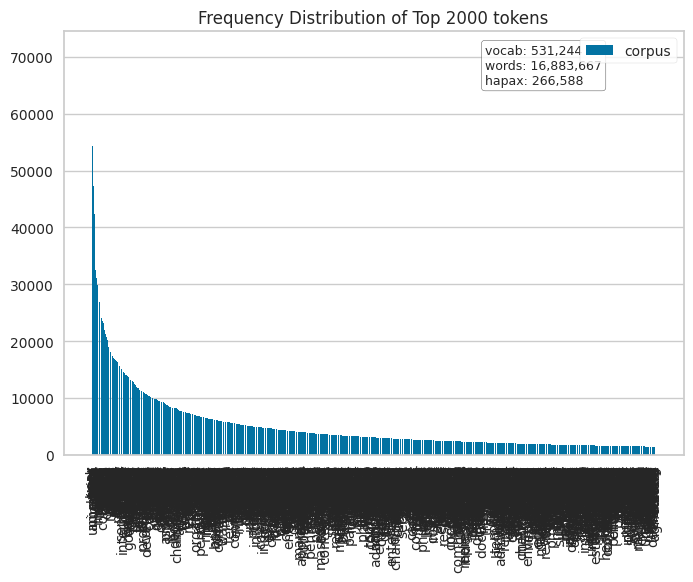

<AxesSubplot: title={'center': 'Frequency Distribution of Top 2000 tokens'}>

In [20]:
#Graph for Human Text Only

human = wiki[0:150000]

#human_text = human["text"]

vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(human["text"])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v', n=2000)
visualizer.fit(docs)
visualizer.show()

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


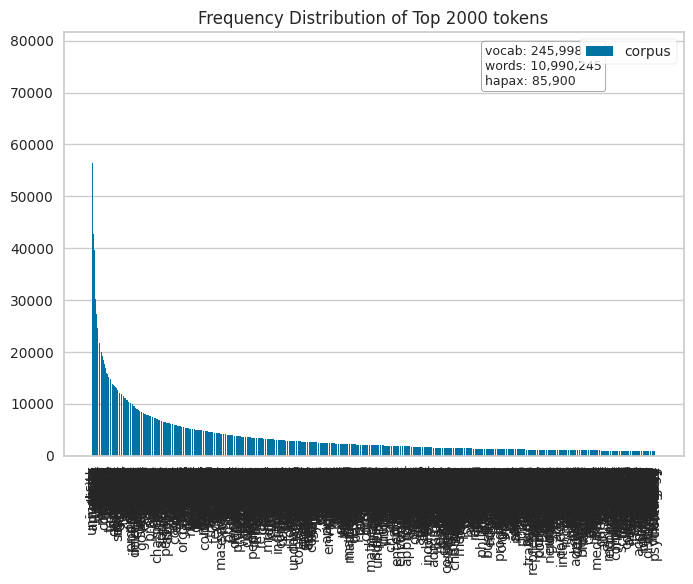

<AxesSubplot: title={'center': 'Frequency Distribution of Top 2000 tokens'}>

In [7]:
#Graph for AI Generated Text Only
ai = wiki[150001:300000]

#human_text = human["text"]

vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(ai["text"])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v', n=2000)
visualizer.fit(docs)
visualizer.show()

Test Train Split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(wiki["text"], wiki['is_generated'], test_size=0.3, random_state=42)

In [5]:
count_vect = CountVectorizer()
temp = count_vect.fit_transform(np.array(x_train))
tfidfconverter = TfidfTransformer(use_idf=True)
temp = tfidfconverter.fit_transform(temp)
temp.shape


(210000, 473219)

Bernoulli Naive Bayes: Setting our benchmark and feature count selection

In [8]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer()),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

start = time.time()


params = {
    'vect__max_features' : [None, 209622, 100000, 75000, 65000, 50000],
}
 
grid = GridSearchCV(nbtext_clf, params, cv = 5, n_jobs=1)
grid.fit(x_train, y_train)

end = time.time()
print((end - start) / 60)


df_cv_scores=pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()
print(grid.best_params_)
df_cv_scores


7.263968658447266
{'vect__max_features': 100000}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      11.426479      0.062124         2.430522        0.024482   
1      11.535133      0.169708         2.554580        0.091394   
3      11.488731      0.149778         2.465323        0.038511   
4      11.455014      0.119854         2.551143        0.087331   
5      11.567802      0.171066         2.470776        0.058425   
0      11.550073      0.179095         2.618717        0.084077   

  param_vect__max_features                          params  split0_test_score  \
2                   100000  {'vect__max_features': 100000}           0.895810   
1                   209622  {'vect__max_features': 209622}           0.894810   
3                    75000   {'vect__max_features': 75000}           0.894833   
4                    65000   {'vect__max_features': 65000}           0.894452   
5                    50000   {'vect__max_features': 50000}           0.892690   
0                     None    {'vect__max_features': None}           0.890333   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
2           0.897190           0.893738           0.895381           0.898810   
1           0.896929           0.893071           0.894048           0.898548   
3           0.896262           0.892976           0.894714           0.897786   
4           0.895952           0.892357           0.894476           0.897571   
5           0.895643           0.891119           0.893310           0.896405   
0           0.890333           0.887452           0.887762           0.891357   

   mean_test_score  std_test_score  rank_test_score  
2         0.896186        0.001713                1  
1         0.895481        0.001991                2  
3         0.895314        0.001616                3  
4         0.894962        0.001736                4  
5         0.893833        0.001941                5  
0         0.889448        0.001552                6

Benoulli NB Accuracy:0.8923666666666666


<AxesSubplot: >

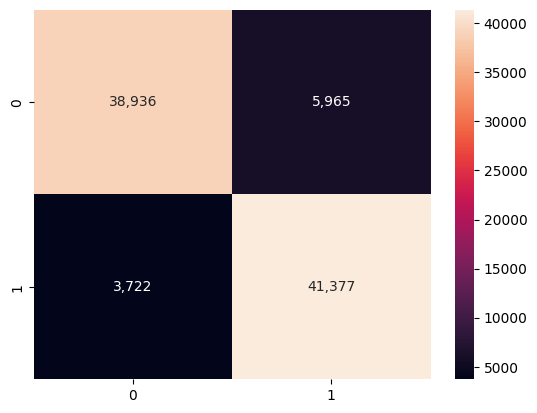

In [9]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer()),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

nbtext_clf.fit(x_train, y_train)
doc_test = x_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Benoulli NB Accuracy:0.8979666666666667


<AxesSubplot: >

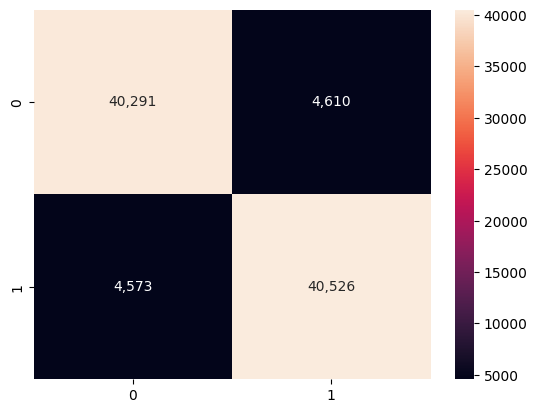

In [5]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer(max_features=209622)),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

nbtext_clf.fit(x_train, y_train)
doc_test = x_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Benoulli NB Accuracy:0.8957


<AxesSubplot: >

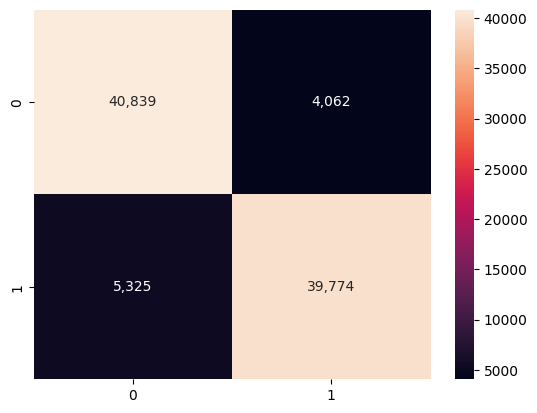

In [7]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer(max_features=50000)),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

nbtext_clf.fit(x_train, y_train)
doc_test = x_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Benoulli NB Accuracy:0.8973222222222222


<AxesSubplot: >

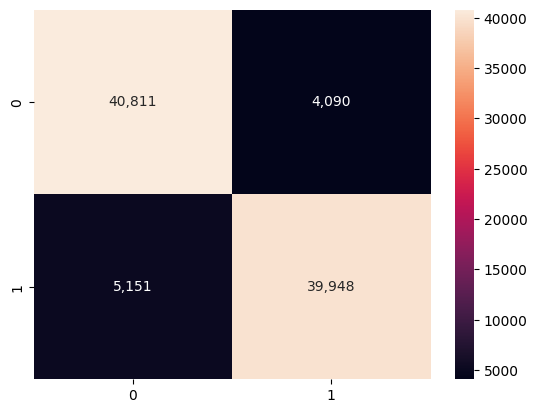

In [8]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer(max_features=75000)),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

nbtext_clf.fit(x_train, y_train)
doc_test = x_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Benoulli NB Accuracy:0.8970333333333333


<AxesSubplot: >

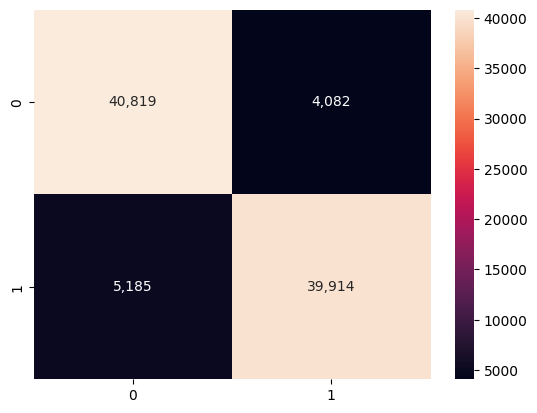

In [12]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer(max_features=65000)),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

nbtext_clf.fit(x_train, y_train)
doc_test = x_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Cross Validation and Hyperparameter Tuning

In [4]:
## CREATE FUNCTION TO DO TFIDF VECTORIZATION
def tfidf(x_train, x_test, n_features):
    count_vect = CountVectorizer(max_features=n_features)
    temp = count_vect.fit_transform(np.array(x_train))
    temp2 = count_vect.transform(np.array(x_test))
    tfidfconverter = TfidfTransformer(use_idf=True)
    temp = tfidfconverter.fit_transform(temp)
    temp2 = tfidfconverter.transform(temp2)
    return temp, temp2

Testing Linear

In [7]:
tx_train, tx_test = tfidf(x_train, x_test, 100000)
start = time.time()

text_clf = Pipeline([
      ('clf', SVC(max_iter=1000, cache_size=15000)),
  ])

params = {
    'clf__kernel' : ['linear'],
    'clf__C' : [0.1, 1, 10, 100]
}
 
grid = GridSearchCV(text_clf, params, cv = 5, n_jobs=1)
grid.fit(tx_train, y_train)

end = time.time()
print((end - start) / 60)


df_cv_scores=pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()
print(grid.best_params_)
df_cv_scores

99.85600920915604
{'clf__C': 1, 'clf__kernel': 'linear'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C  \
1     118.195213      1.476966        13.226665        0.096162            1   
2     472.175305      4.919149        10.140800        0.235778           10   
0      63.467894      0.646343        20.880096        0.260870          0.1   
3     451.679212      3.024758         9.099682        0.140901          100   

  param_clf__kernel                                    params  \
1            linear    {'clf__C': 1, 'clf__kernel': 'linear'}   
2            linear   {'clf__C': 10, 'clf__kernel': 'linear'}   
0            linear  {'clf__C': 0.1, 'clf__kernel': 'linear'}   
3            linear  {'clf__C': 100, 'clf__kernel': 'linear'}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.906929           0.906500           0.905190           0.905619   
2           0.894595           0.893381           0.893452           0.892952   
0           0.889095           0.888905           0.888357           0.890500   
3           0.872381           0.872500           0.873762           0.872714   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.906095         0.906067        0.000616                1  
2           0.893071         0.893490        0.000583                2  
0           0.890833         0.889538        0.000959                3  
3           0.872619         0.872795        0.000496                4

In [9]:
df_cv_scores.to_csv('gridsearch_cv_linear.csv', index=False)

Testing RBF

In [7]:
tx_train, tx_test = tfidf(x_train, x_test, 100000)
start = time.time()

text_clf = Pipeline([
      ('clf', SVC(max_iter=1000, cache_size=10000)),
  ])

params = {
    'clf__kernel' : ['rbf'],
    'clf__gamma' : ['scale', 0.1, 0.01],
    'clf__C' : [1, 10, 100]
}
 
grid = GridSearchCV(text_clf, params, cv = 5)
grid.fit(tx_train, y_train)

end = time.time()
print((end - start) / 60)


df_cv_scores=pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()
print(grid.best_params_)
df_cv_scores

181.8079835096995
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C  \
3     247.776791      0.812944        23.616194        0.196980           10   
6     247.933146      1.363356        23.571891        0.217268          100   
0     168.876816      1.139374        22.498091        0.112906            1   
4     217.937063      2.068987        14.322125        0.154831           10   
8     246.281067      1.350821        13.429819        0.134270          100   
7     570.001440      3.687827        13.510836        0.181899          100   
5      70.283308      0.477369        19.786373        0.152108           10   
1      71.526233      0.589182        20.710277        0.237991            1   
2      82.635438      0.552685        32.630385        0.141766            1   

  param_clf__gamma param_clf__kernel  \
3            scale               rbf   
6            scale               rbf   
0            scale               rbf   
4              0.1               rbf   
8             0.01               rbf   
7              0.1               rbf   
5             0.01               rbf   
1              0.1               rbf   
2             0.01               rbf   

                                              params  split0_test_score  \
3  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...           0.919190   
6  {'clf__C': 100, 'clf__gamma': 'scale', 'clf__k...           0.919190   
0  {'clf__C': 1, 'clf__gamma': 'scale', 'clf__ker...           0.913810   
4  {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel...           0.909286   
8  {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kern...           0.904905   
7  {'clf__C': 100, 'clf__gamma': 0.1, 'clf__kerne...           0.902786   
5  {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kerne...           0.898643   
1  {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel'...           0.898452   
2  {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel...           0.853667   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
3           0.918881           0.918333           0.918857           0.919619   
6           0.918881           0.918333           0.918857           0.919524   
0           0.913357           0.913738           0.913905           0.914690   
4           0.909286           0.908024           0.908119           0.908881   
8           0.905048           0.904571           0.903857           0.904524   
7           0.902429           0.901214           0.901214           0.901929   
5           0.897619           0.896952           0.898619           0.899048   
1           0.896500           0.896714           0.898048           0.898595   
2           0.854262           0.852024           0.854381           0.853024   

   mean_test_score  std_test_score  rank_test_score  
3         0.918976        0.000423                1  
6         0.918957        0.000395                2  
0         0.913900        0.000437                3  
4         0.908719        0.000550                4  
8         0.904581        0.000412                5  
7         0.901914        0.000633                6  
5         0.898176        0.000772                7  
1         0.897662        0.000882                8  
2         0.853471        0.000870                9

In [9]:
df_cv_scores.to_csv('gridsearch_cv_rbf.csv', index=False)

## Evaluating Models on Test Data

Benoulli NB Accuracy:0.8978555555555555


<AxesSubplot: >

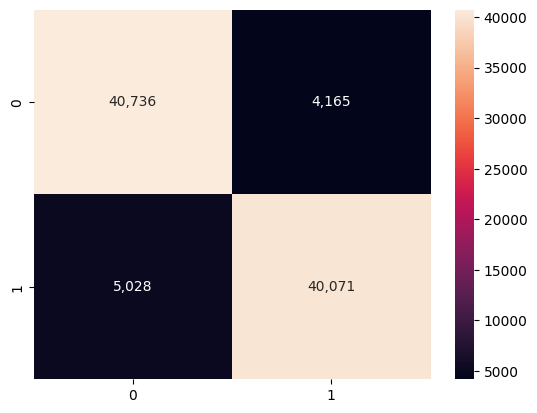

In [6]:
nbtext_clf = Pipeline([
      ('vect', CountVectorizer(max_features=100000)),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf', BernoulliNB()),
  ])

nbtext_clf.fit(x_train, y_train)
doc_test = x_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Linear kernel after Hyperparameter Tuning, accuracy:0.9130888888888888, with Params:{'clf__C': 1, 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     44901
           1       0.92      0.91      0.91     45099

    accuracy                           0.91     90000
   macro avg       0.91      0.91      0.91     90000
weighted avg       0.91      0.91      0.91     90000



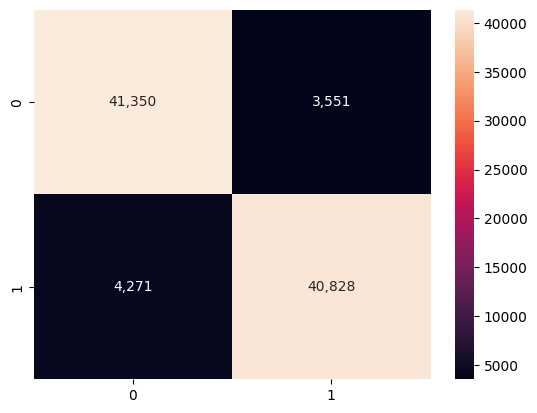

In [8]:
doc_test = tx_test
predicted = grid.predict(doc_test)
print('Linear kernel after Hyperparameter Tuning, accuracy:{}'.format(np.mean(predicted ==  y_test)) +", with Params:" + str(grid.best_params_)) 
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

print(classification_report(y_test, predicted))

RBF kernel after Hyperparameter Tuning, accuracy:0.9274888888888889, with Params:{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     44901
           1       0.93      0.92      0.93     45099

    accuracy                           0.93     90000
   macro avg       0.93      0.93      0.93     90000
weighted avg       0.93      0.93      0.93     90000



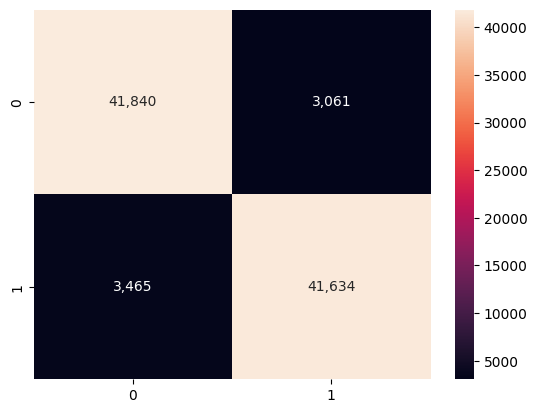

In [8]:
doc_test = tx_test
predicted = grid.predict(doc_test)
print('RBF kernel after Hyperparameter Tuning, accuracy:{}'.format(np.mean(predicted ==  y_test)) +", with Params:" + str(grid.best_params_)) 
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

print(classification_report(y_test, predicted))

## Test: Add "length" feature to our TFIDF vectors

In [4]:
x_train, x_test, y_train, y_test = train_test_split(wiki[["text", "length"]], wiki['is_generated'], test_size=0.3, random_state=42)


In [5]:
x_train

text  length
186295  constancio jurgens , c.i.c.m. ( 12 december 18...     118
127847  mauger norman surname germanic origin ( possib...     167
274740  fleeting ends rock band united states . band r...     189
74908   modern , scientific psychology date 1879 openi...     176
11630   robert józef kubica (; bear 7 december 1984 ) ...     241
...                                                   ...     ...
119879  outserve magazine bi - monthly digital print p...     242
259178  eastern armenia ( arevelyan hayastan ) exclave...     171
131932  infinity group private equity fund back china ...     151
146867  kattinakere ( ಕಟ್ಟಿನಕೆರೆ ) call b sagadde haml...     268
121958  wei yan   ( die 234 ) , courtesy wenchang , mi...     254

[210000 rows x 2 columns]

Using ColumnTransformer to concatenate features

Normalization

In [6]:
ct = ColumnTransformer(
    [
    ('text', TfidfVectorizer(max_features=100000), 'text'),
    ('length', MinMaxScaler(), ['length'])
    ],
    remainder='passthrough'
)
nlx_train = ct.fit_transform(x_train)
nlx_test = ct.transform(x_test)

In [7]:
print(nlx_train.shape)
print(nlx_test.shape)

print(nlx_train)


(210000, 100001)
(90000, 100001)
  (0, 379)	0.057571554843711306
  (0, 1212)	0.08975267510762235
  (0, 1258)	0.08182280266090525
  (0, 1261)	0.0770174963341592
  (0, 1266)	0.07961613359969208
  (0, 1276)	0.07743265409731837
  (0, 1304)	0.07423408902459155
  (0, 1315)	0.14825193826950367
  (0, 1451)	0.06418587599365332
  (0, 1515)	0.060210998736616506
  (0, 1941)	0.07106904128440115
  (0, 2333)	0.0931637032377451
  (0, 3100)	0.0590080110640559
  (0, 4037)	0.0975792722225133
  (0, 8588)	0.08810488281096275
  (0, 10685)	0.060602866778122245
  (0, 11035)	0.09210089615906725
  (0, 11040)	0.08769944393496068
  (0, 11478)	0.07547961019205496
  (0, 14767)	0.20792766538297855
  (0, 17877)	0.08165509043598905
  (0, 18571)	0.0679354313635559
  (0, 18878)	0.10276113650699308
  (0, 19502)	0.07726722412580855
  (0, 20632)	0.13945139881340685
  :	:
  (209999, 74562)	0.04962469015660587
  (209999, 76001)	0.03308137941590133
  (209999, 76074)	0.04259499797424184
  (209999, 79380)	0.03258577595591377
  

Standardization

In [12]:
ct1 = ColumnTransformer(
    [
    ('text', TfidfVectorizer(max_features=65000), 'text'),
    ('length', StandardScaler(), ['length'])
    ],
    remainder='passthrough'
)
slx_train = ct1.fit_transform(x_train)
slx_test = ct1.transform(x_test)

In [9]:
print(slx_train.shape)
print(slx_test.shape)

print(slx_train)

NameError: name 'slx_train' is not defined

In [ ]:
Testing Naive Bayes with new Length Data

[0.89285714 0.89633333 0.89109524 0.89385714 0.89595238]
0.894019048 accuracy with a standard deviation of 0.00

 Evaluation on Test data
Benoulli NB Accuracy:0.8959555555555555


<AxesSubplot: >

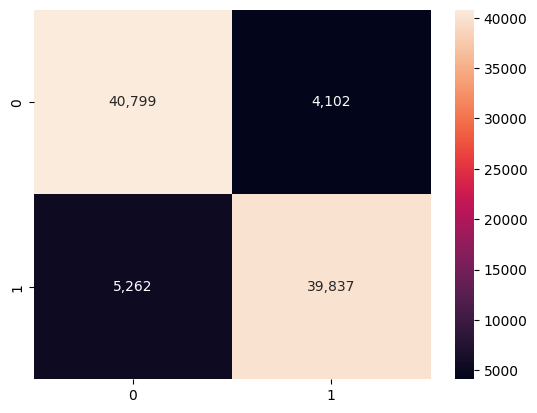

In [14]:
## USING STANDARDIZED
nbtext_clf = Pipeline([
      ('clf', BernoulliNB()),
  ])


scores = cross_val_score(nbtext_clf, slx_train, y_train, cv=5)
print(scores)
print("%0.9f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

print("\n Evaluation on Test data")

nbtext_clf.fit(slx_train, y_train)
doc_test = slx_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

[0.89564286 0.89709524 0.89347619 0.89552381 0.89892857]
0.896133333 accuracy with a standard deviation of 0.00

 Evaluation on Test data
Benoulli NB Accuracy:0.8978555555555555


<AxesSubplot: >

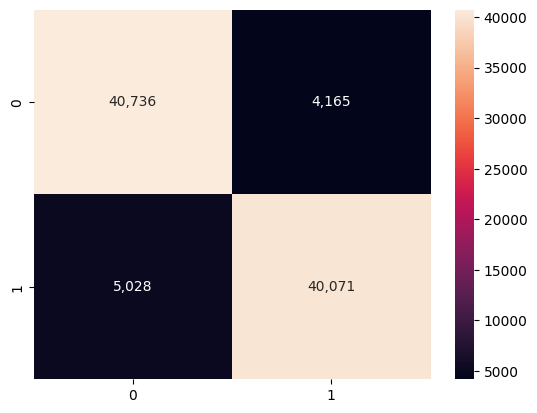

In [15]:
## USING NORMALIZED
nbtext_clf = Pipeline([
      ('clf', BernoulliNB()),
  ])

scores = cross_val_score(nbtext_clf, nlx_train, y_train, cv=5)
print(scores)
print("%0.9f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

print("\n Evaluation on Test data")
nbtext_clf.fit(nlx_train, y_train)
doc_test = nlx_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy:{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

## Testing Linear SVM with Normalized Length

In [16]:
start = time.time()

text_clf = Pipeline([
      ('clf', SVC(max_iter=1000, cache_size=15000)),
  ])

params = {
    'clf__kernel' : ['linear'],
    'clf__C' : [0.1, 1, 10, 100]
}
 
grid = GridSearchCV(text_clf, params, cv = 5, n_jobs=1)
grid.fit(nlx_train, y_train)

end = time.time()
print((end - start) / 60)


df_cv_scores=pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()
print(grid.best_params_)
df_cv_scores

df_cv_scores.to_csv('gridsearch_cv_linear_with_length_normalized.csv', index=False)

92.66128574609756
{'clf__C': 1, 'clf__kernel': 'linear'}


In [18]:
df_cv_scores

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C  \
1      92.981877      1.195647        10.752287        0.091533            1   
2     437.355937      5.421248         8.519608        0.095199           10   
0      51.261111      0.588842        15.423969        0.203831          0.1   
3     455.551992      1.553079         7.992961        0.111707          100   

  param_clf__kernel                                    params  \
1            linear    {'clf__C': 1, 'clf__kernel': 'linear'}   
2            linear   {'clf__C': 10, 'clf__kernel': 'linear'}   
0            linear  {'clf__C': 0.1, 'clf__kernel': 'linear'}   
3            linear  {'clf__C': 100, 'clf__kernel': 'linear'}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.925595           0.922881           0.924714           0.923429   
2           0.912929           0.912452           0.912405           0.910024   
0           0.906619           0.908024           0.905214           0.903833   
3           0.896571           0.896786           0.896024           0.892643   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.924452         0.924214        0.000960                1  
2           0.913833         0.912329        0.001262                2  
0           0.906238         0.905986        0.001403                3  
3           0.895976         0.895600        0.001511                4

Linear kernel after Hyperparameter Tuning with Length Feature, Normalized, accuracy:0.9282888888888889, with Params:{'clf__C': 1, 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     44901
           1       0.94      0.92      0.93     45099

    accuracy                           0.93     90000
   macro avg       0.93      0.93      0.93     90000
weighted avg       0.93      0.93      0.93     90000



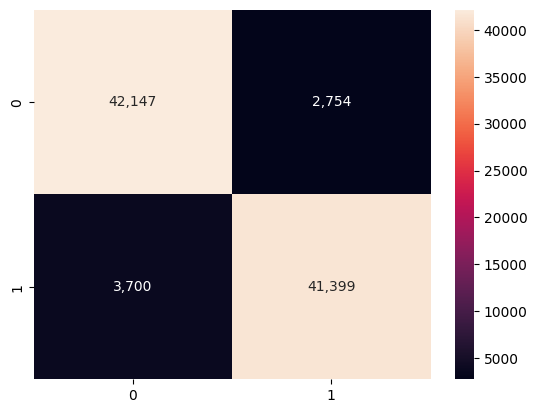

In [17]:
doc_test = nlx_test
predicted = grid.predict(doc_test)
print('Linear kernel after Hyperparameter Tuning with Length Feature, Normalized, accuracy:{}'.format(np.mean(predicted ==  y_test)) +", with Params:" + str(grid.best_params_)) 
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

print(classification_report(y_test, predicted))

## Testing Kernel SVM with Normalized Length

In [19]:
start = time.time()

text_clf = Pipeline([
      ('clf', SVC(max_iter=1000, cache_size=10000)),
  ])

params = {
    'clf__kernel' : ['rbf'],
    'clf__gamma' : ['scale', 0.1, 0.01],
    'clf__C' : [1, 10, 100]
}
 
grid = GridSearchCV(text_clf, params, cv = 5)
grid.fit(nlx_train, y_train)

end = time.time()
print((end - start) / 60)


df_cv_scores=pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()
print(grid.best_params_)
df_cv_scores

df_cv_scores.to_csv('gridsearch_cv_rbf_with_length_normalized.csv', index=False)

140.69800384044646
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


RBF kernel after Hyperparameter Tuning with Normalized Length, accuracy:0.9512888888888889, with Params:{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     44901
           1       0.96      0.94      0.95     45099

    accuracy                           0.95     90000
   macro avg       0.95      0.95      0.95     90000
weighted avg       0.95      0.95      0.95     90000



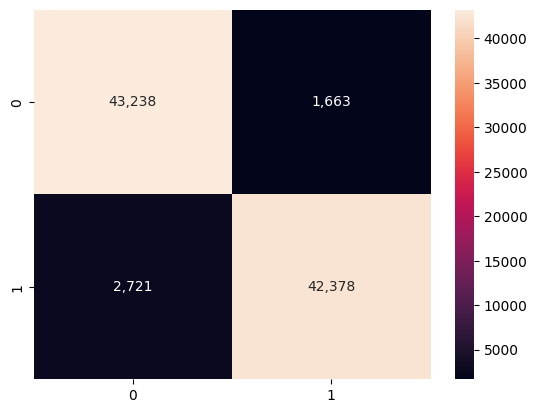

In [20]:
doc_test = nlx_test
predicted = grid.predict(doc_test)
print('RBF kernel after Hyperparameter Tuning with Normalized Length, accuracy:{}'.format(np.mean(predicted ==  y_test)) +", with Params:" + str(grid.best_params_)) 
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

print(classification_report(y_test, predicted))

## Dimensionality Reduction using Latent Semanatic Analysis

In [5]:
def LSA(x_train, x_test, n):
    svd = TruncatedSVD(n_components=n, algorithm='arpack')
    x_train = svd.fit_transform(x_train)
    x_test = svd.transform(x_test)
    return x_train, x_test
    
    


In [16]:
start = time.time()
pipe = Pipeline (
    [ 
        ('dim_reduction', TruncatedSVD()),
        ('clf', SVC(C = 1, kernel = 'linear', max_iter=1000, cache_size=15000, verbose=2))
    ]
)

#print(pipe.get_params())

dim_range = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]


train_score, valid_score = validation_curve(pipe, nlx_train, y_train, param_name="dim_reduction__n_components", param_range = dim_range, cv=5, scoring = "accuracy")

end = time.time()
print((end - start) / 60)


144.6884459455808


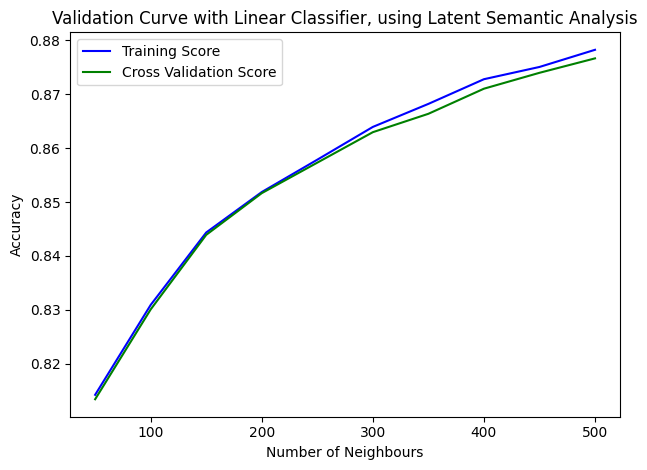

In [17]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_valid_score = np.mean(valid_score, axis = 1)
std_valid_score = np.std(valid_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(dim_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(dim_range, mean_valid_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Linear Classifier, using Latent Semantic Analysis")
plt.xlabel("Number of Dimensions")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [8]:
start = time.time()
pipe = Pipeline (
    [ 
        ('dim_reduction', TruncatedSVD()),
        ('clf', SVC(C = 10, kernel = 'rbf', gamma = 'scale', max_iter=1000, cache_size=15000, verbose=2))
    ]
)

#print(pipe.get_params())

dim_range = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]


train_score, valid_score = validation_curve(pipe, nlx_train, y_train, param_name="dim_reduction__n_components", param_range = dim_range, cv=5, scoring = "accuracy")

end = time.time()
print((end - start) / 60)

204.30662027597427


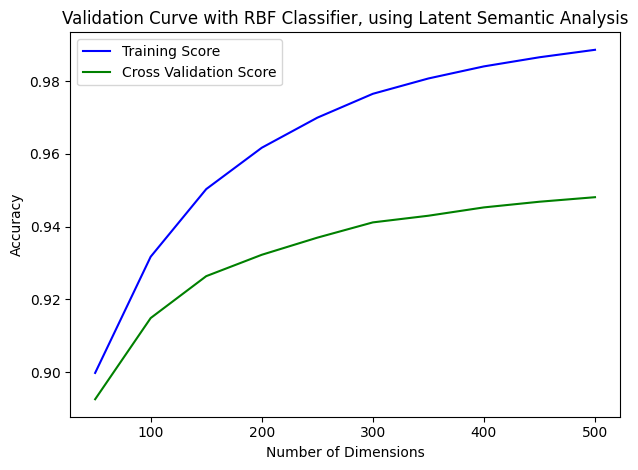

In [9]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_valid_score = np.mean(valid_score, axis = 1)
std_valid_score = np.std(valid_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(dim_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(dim_range, mean_valid_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with RBF Classifier, using Latent Semantic Analysis")
plt.xlabel("Number of Dimensions")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [11]:
start = time.time()
pipe = Pipeline (
    [ 
        ('dim_reduction', TruncatedSVD()),
        ('clf', BernoulliNB())
    ]
)

#print(pipe.get_params())

dim_range = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]


train_score, valid_score = validation_curve(pipe, nlx_train, y_train, param_name="dim_reduction__n_components", param_range = dim_range, cv=5, scoring = "accuracy")

end = time.time()
print((end - start) / 60)

58.603881831963854


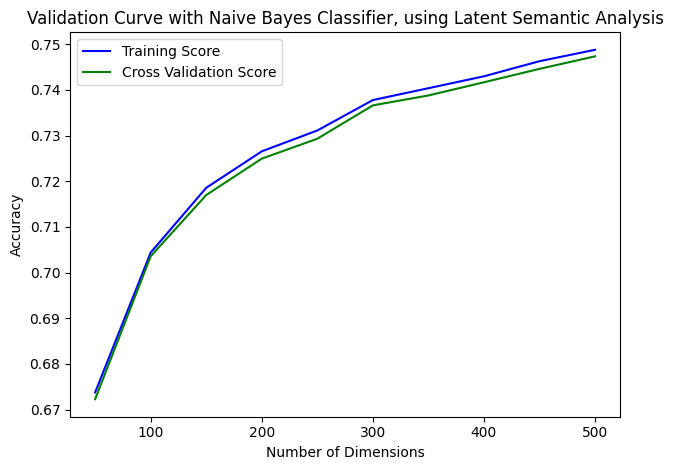

In [12]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_valid_score = np.mean(valid_score, axis = 1)
std_valid_score = np.std(valid_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(dim_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(dim_range, mean_valid_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Naive Bayes Classifier, using Latent Semantic Analysis")
plt.xlabel("Number of Dimensions")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

Benoulli NB Accuracy with Normalized Length, and LSA reduction to 500 :0.7481777777777778


<AxesSubplot: >

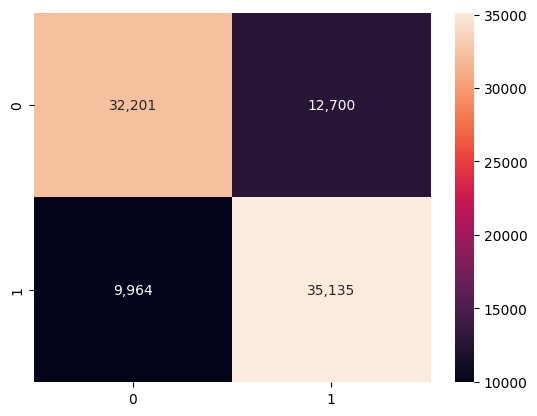

In [13]:
nbtext_clf = Pipeline (
    [ 
        ('dim_reduction', TruncatedSVD(500)),
        ('clf', BernoulliNB())
    ]
)

nbtext_clf.fit(nlx_train, y_train)
doc_test = nlx_test
predicted = nbtext_clf.predict(doc_test)
print('Benoulli NB Accuracy with Normalized Length, and LSA reduction to 500 :{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

Linear Kernel Accuracy with Normalized Length, and LSA reduction to 500 :0.8788666666666667


<AxesSubplot: >

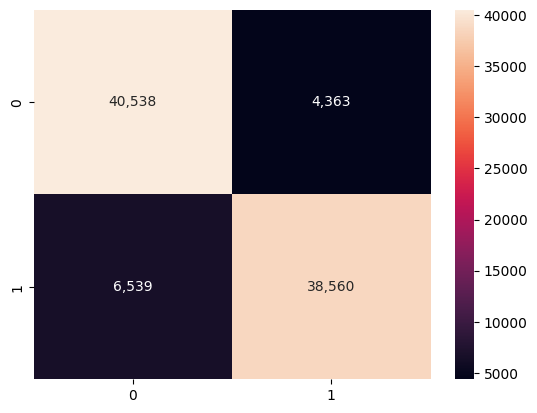

In [17]:
text_clf = Pipeline (
    [ 
        ('dim_reduction', TruncatedSVD(500)),
        ('clf', SVC(C = 1, kernel = 'linear', max_iter=1000, cache_size=15000, verbose=2))
    ]
)

text_clf.fit(nlx_train, y_train)
doc_test = nlx_test

predicted = text_clf.predict(doc_test)
print('Linear Kernel Accuracy with Normalized Length, and LSA reduction to 500 :{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')

RBF Kernel Accuracy with Normalized Length, and LSA reduction to 500 :0.952


<AxesSubplot: >

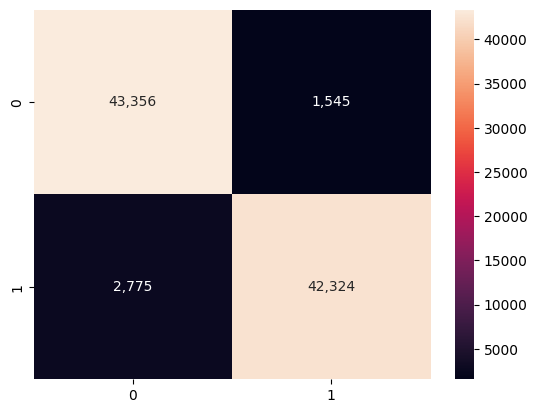

In [18]:
text_clf = Pipeline (
    [ 
        ('dim_reduction', TruncatedSVD(500)),
        ('clf', SVC(C = 10, kernel = 'rbf', gamma = 'scale', max_iter=1000, cache_size=15000, verbose=2))
    ]
)

text_clf.fit(nlx_train, y_train)
doc_test = nlx_test
predicted = text_clf.predict(doc_test)
print('RBF Kernel Accuracy with Normalized Length, and LSA reduction to 500 :{}'.format(np.mean(predicted ==  y_test)))
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt=',d')